Tests on parts of  NA12878 data for Del_st, Del_end and No_sv, ground  truth Mills_nanosv. Very unbalanced dataset.

## Load dependences and setting output configuration

In [58]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\sonja\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load data from npy files

In [59]:
import pickle
dico = pickle.load(open("F:/1_GTCG/data/11092018/labels.pickle/labels.pickle", "rb"))
data_labels = dataset = dico["Mills2011_nanosv"]
window_size = 200

In [60]:
dico = []

In [61]:
replications = 16
factor_nosv = 1 

In [62]:
datapath = 'F:/1_GTCG/data/TestData_060818.tar/TestData_060818/NA12878' 

germline_1_datapath = datapath + '/ChannelData/unzipped/'
ger_1_labels_datapath = datapath + '/LabelData/unzipped/'

G1_data_SV = np.empty([0, 27, window_size])
G1_labels_SV =[]
G1_data_noSV = np.empty([0, 27, window_size])
G1_labels_noSV =[]
total_train_sv_windows = 0
for i in range(16,23,1):#test on chr >= 16
        G1_data_new =np.load(germline_1_datapath + str(i) + '_channel_maker_real_germline.npy/' + str(i) +'_channel_maker_real_germline.npy')
        #G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy/' +str(i) +'_label_ci_full_overlap.npy') 
        G1_labels_new = np.array(data_labels[str(i)])
        print(G1_labels_new[0])
        G1_data_new = G1_data_new[np.where(G1_labels_new != 'UK')]
        G1_labels_new = G1_labels_new[np.where(G1_labels_new != 'UK')]
        G1_data_SV_new  = G1_data_new[np.where(G1_labels_new != 'noSV')]
        G1_labels_SV_new  = G1_labels_new[np.where(G1_labels_new != 'noSV')]
        n_windows_sv = G1_data_SV_new.shape[0]
        G1_data_noSV_new  = G1_data_new[np.where(G1_labels_new == 'noSV')]
        G1_labels_noSV_new  = G1_labels_new[np.where(G1_labels_new == 'noSV')]
        #G1_data_noSV_new =  G1_data_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)]
        #G1_labels_noSV_new =  G1_labels_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)]
        print(str(i) + ':' + str(G1_data_SV_new.shape))
        #print(G1_labels_SV_new[0])
        G1_data_SV = np.concatenate((G1_data_SV, G1_data_SV_new))
        G1_labels_SV = np.concatenate((G1_labels_SV, G1_labels_SV_new))
        G1_data_noSV = np.concatenate((G1_data_noSV, G1_data_noSV_new))
        G1_labels_noSV = np.concatenate((G1_labels_noSV, G1_labels_noSV_new))
        if i < 16: #for training until chromozome 16
            total_train_sv_windows += G1_data_SV_new.shape[0]

noSV
16:(47, 27, 200)
noSV
17:(48, 27, 200)
noSV
18:(77, 27, 200)
noSV
19:(44, 27, 200)
noSV
20:(58, 27, 200)
noSV
21:(28, 27, 200)
noSV
22:(21, 27, 200)


### Find  the indexes that split the categories

In [63]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [64]:
#find_splitting_indices(G1_labels)

In [65]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [66]:
sv=G1_data_SV.shape[0]

In [67]:
sv

323

In [68]:
int(sv/2)

161

In [69]:
#G1_data_noSV  = G1_data_noSV[0:2*sv] 

In [70]:
#G1_labels_noSV  = G1_labels_noSV[0:2*sv] 

In [71]:
SV_train =  0 #int(0.8 * total_train_sv_windows)
noSV_train = 0 #int(replications * SV_train / 2/factor_nosv)

SV_val = 0 # total_train_sv_windows - SV_train
noSV_val = 0 # int(replications * SV_val / 2/factor_nosv)

In [72]:
def replicate(data, start, end, howmanytimes): 
    X = data[start:end]
    for i in range(0,howmanytimes):
        X = np.concatenate((X, data[start:end]))
    return X 

In [73]:
replications = 1#no rep for testing
X_train = replicate(G1_data_SV, 0, SV_train, replications)
y_train = replicate(G1_labels_SV, 0, SV_train,replications)
X_val = replicate(G1_data_SV, SV_train, SV_train+SV_val, replications)
y_val = replicate(G1_labels_SV, SV_train, SV_train+SV_val, replications)
X_test = replicate(G1_data_SV, SV_train+SV_val, len(G1_data_SV), replications)
y_test = replicate(G1_labels_SV, SV_train+SV_val, len(G1_labels_SV), replications)

In [74]:
X_train = np.concatenate((X_train, G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((X_val, G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((X_test, G1_data_noSV[noSV_train +noSV_val:]))

In [75]:
G1_data_noSV = []

In [76]:
y_train = np.concatenate((y_train, G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((y_val, G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((y_test, G1_labels_noSV[noSV_train +noSV_val:]))

In [77]:
#G1_labels_noSV = []

In [78]:
y_test

array(['DEL_start', 'DEL_end', 'DEL_start', ..., 'noSV', 'noSV', 'noSV'], 
      dtype='<U32')

### Number of training, validation and test windows

In [79]:
X_train.shape

(0, 27, 200)

In [80]:
X_val.shape

(0, 27, 200)

In [81]:
X_test.shape

(246107, 27, 200)

In [82]:
y_test.shape

(246107,)

In [83]:
number_channels = X_train.shape[1]
number_channels

27

## Normalize data using the reads coverage as parameter and remove uninteresting channels for deletions

In [84]:
coverage = np.median(X_test[:, 0, :]) #the median of the coverage in the normal cells
coverage


42.0

In [85]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [86]:
def eliminate_noise_chanels(X):
    return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    

In [87]:
def eliminate_distance_chanels(X):
    return np.delete(X, [3,4,7,8], axis=1)

In [88]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [89]:
X_train = eliminate_distance_chanels(X_train)
X_val = eliminate_distance_chanels(X_val)
X_test = eliminate_distance_chanels(X_test)

In [90]:
X_train.shape

(0, 5, 200)

In [91]:
number_channels = X_train.shape[1]
number_channels

5

## Differentiate the time series for a zero mean

In [92]:
def differentiate(X):
    for i in range(0, X.shape[0]):        
        for j in range(0, X.shape[1]):
            for k in range(0, X.shape[2]-1):
                X[i][j][k] = X[i][j][k+1] - X[i][j][k]
    return X[:,:,:-1]        

In [93]:
#X_train = differentiate(X_train)

In [94]:
#X_val = differentiate(X_val)
#X_test = differentiate(X_test)

## Plots several  windows

In [95]:
n_windows = 100
label = ["None"] * number_channels

In [96]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [97]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 1):
        #if y_test[i] == labels[predicted[i]]:
            #continue
        #print(y_train[i], 'id:', i)
        print('id:', i)
        print('Nanopore:', y_test[i])#, '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 0
Nanopore: DEL_start


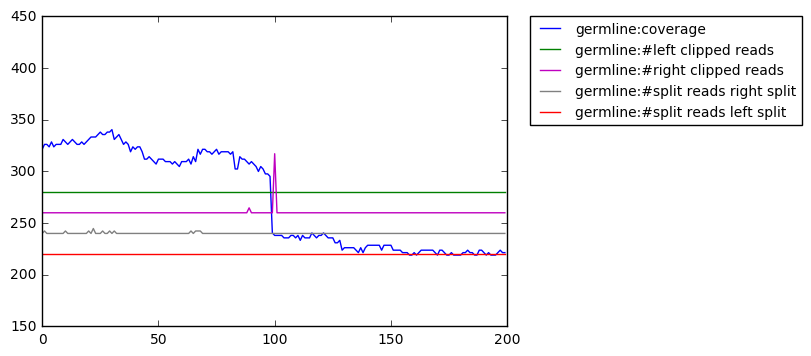

id: 1
Nanopore: DEL_end


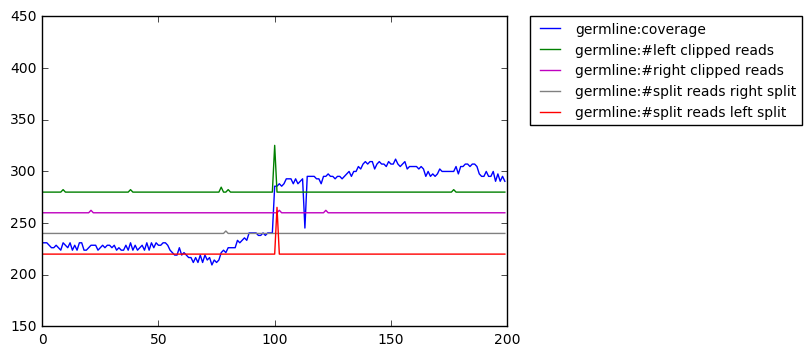

id: 2
Nanopore: DEL_start


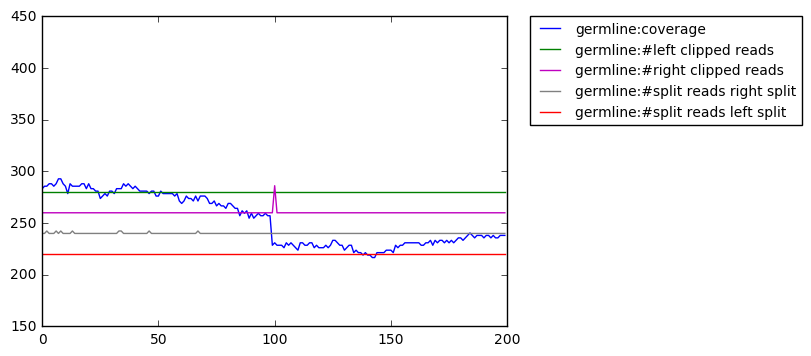

id: 3
Nanopore: DEL_end


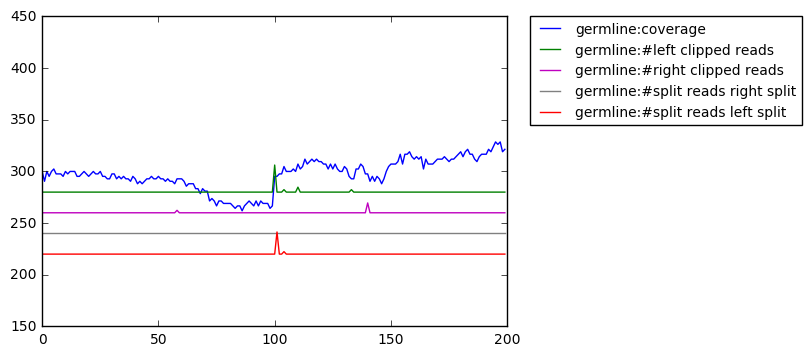

id: 4
Nanopore: DEL_end


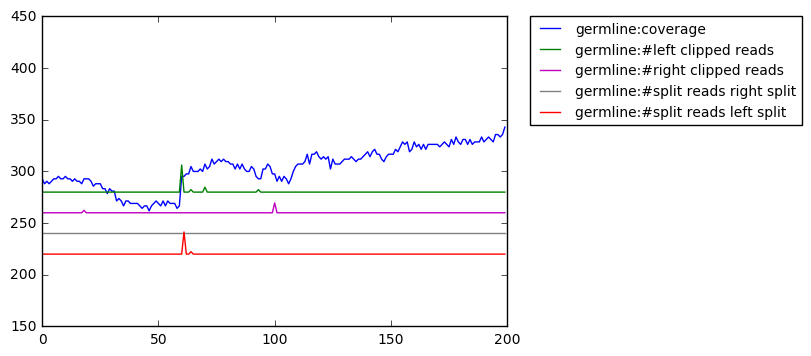

id: 5
Nanopore: DEL_start


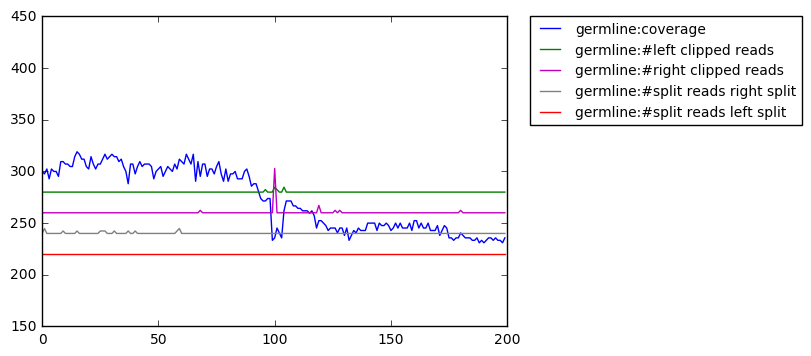

id: 6
Nanopore: DEL_start


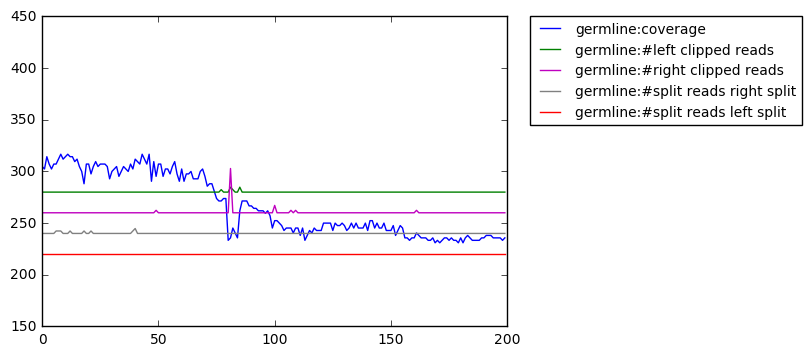

id: 7
Nanopore: DEL_end


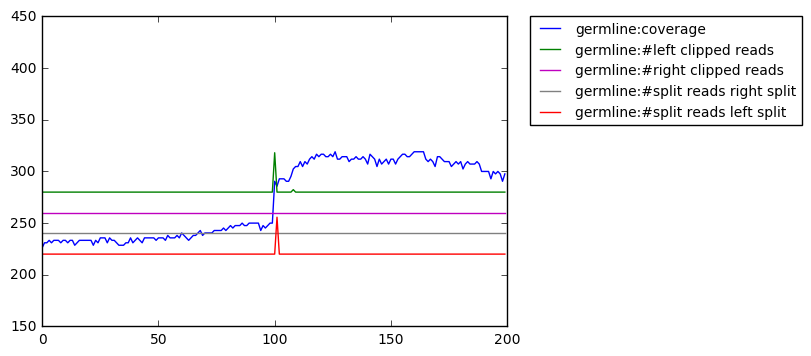

id: 8
Nanopore: DEL_start


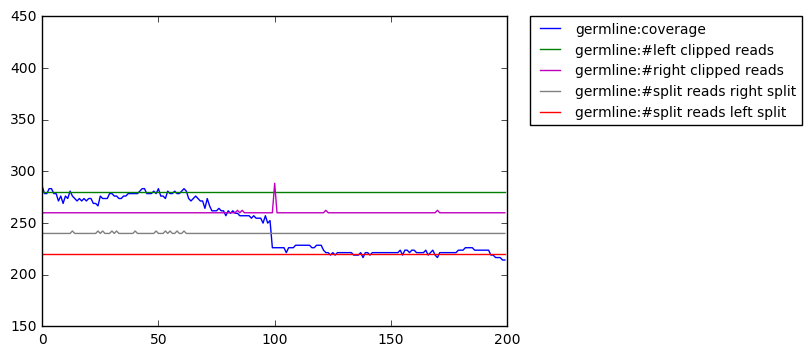

id: 9
Nanopore: DEL_end


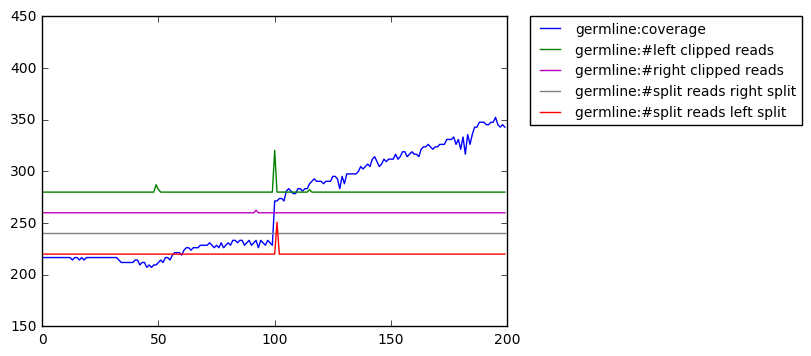

id: 10
Nanopore: DEL_start


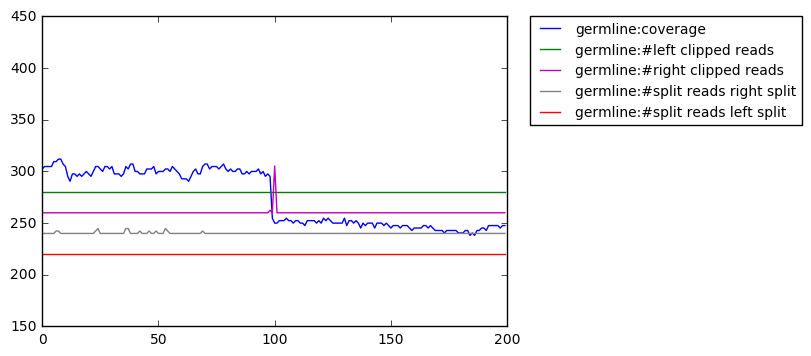

id: 11
Nanopore: DEL_start


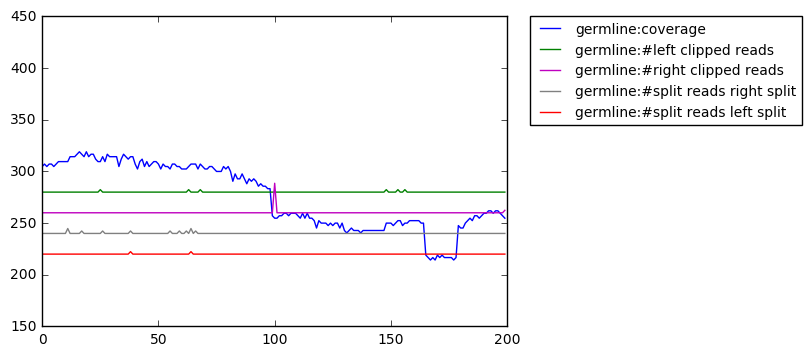

id: 12
Nanopore: DEL_end


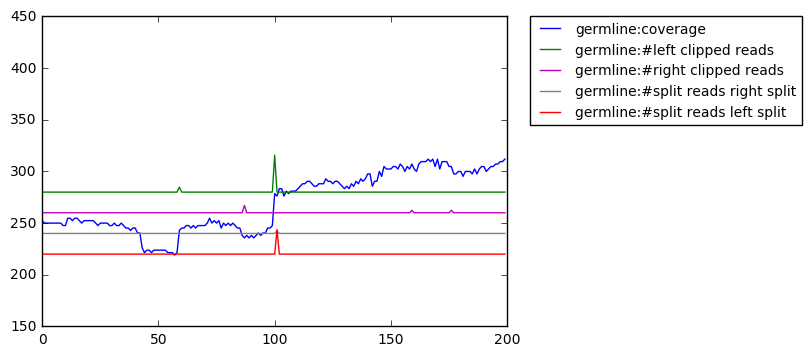

id: 13
Nanopore: DEL_start


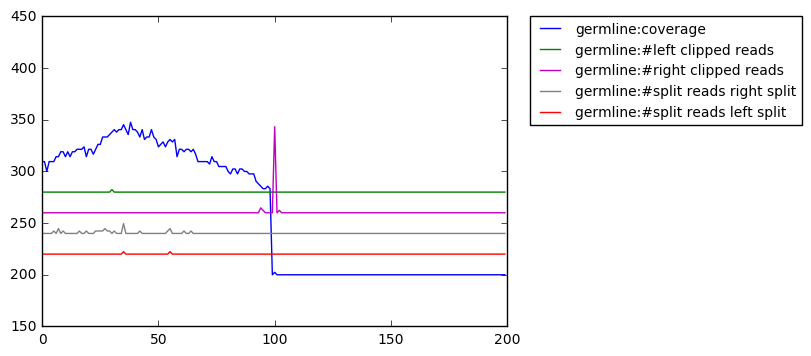

id: 14
Nanopore: DEL_end


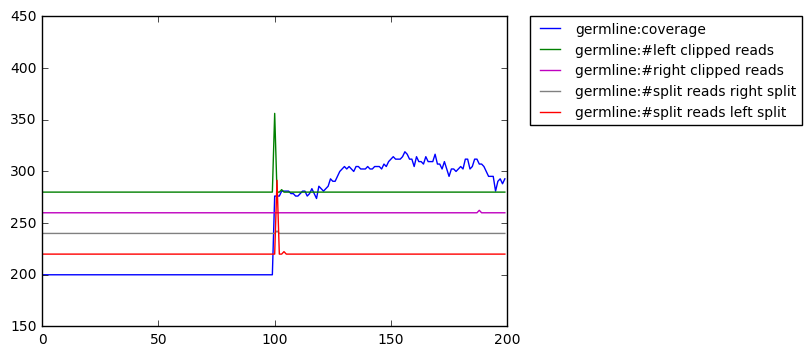

id: 15
Nanopore: DEL_start


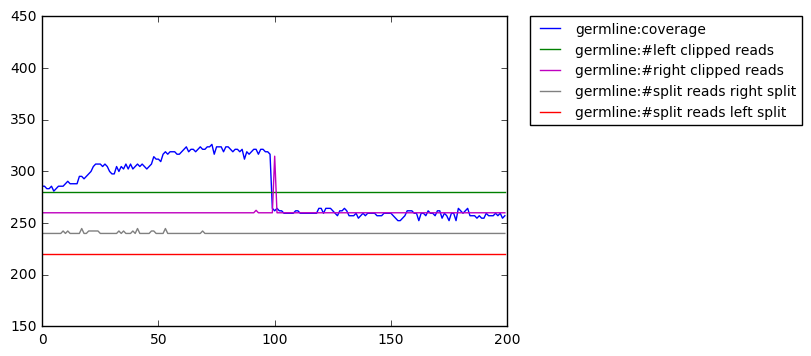

id: 16
Nanopore: DEL_start


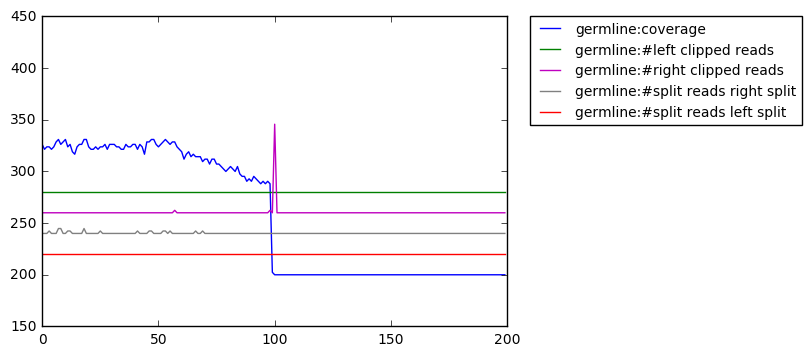

id: 17
Nanopore: DEL_end


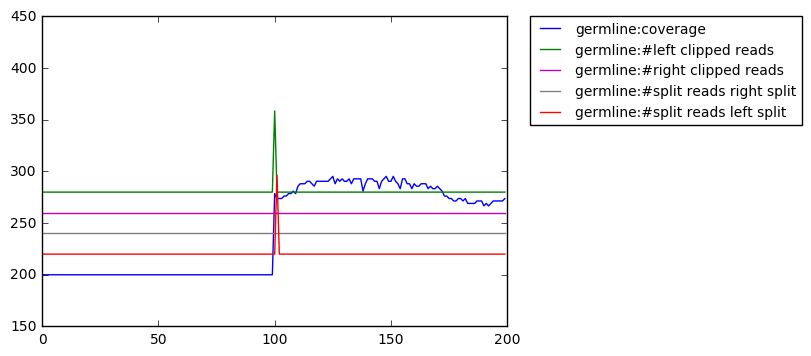

id: 18
Nanopore: DEL_start


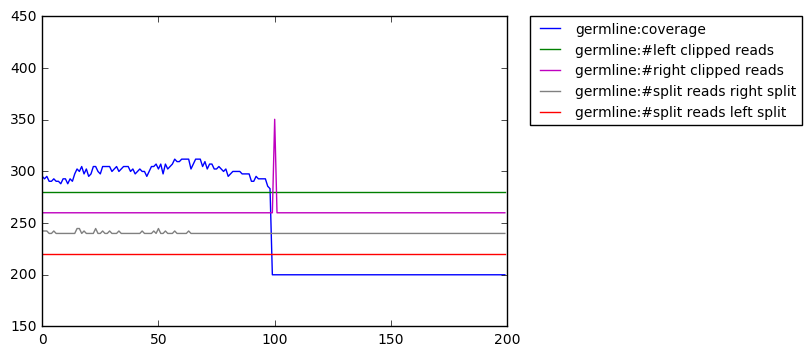

id: 19
Nanopore: DEL_end


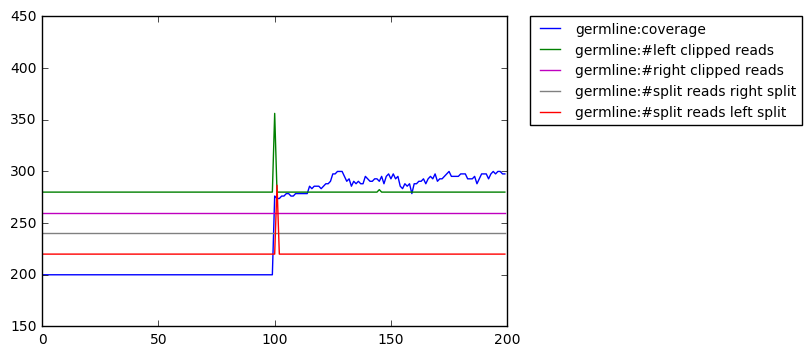

id: 20
Nanopore: DEL_start


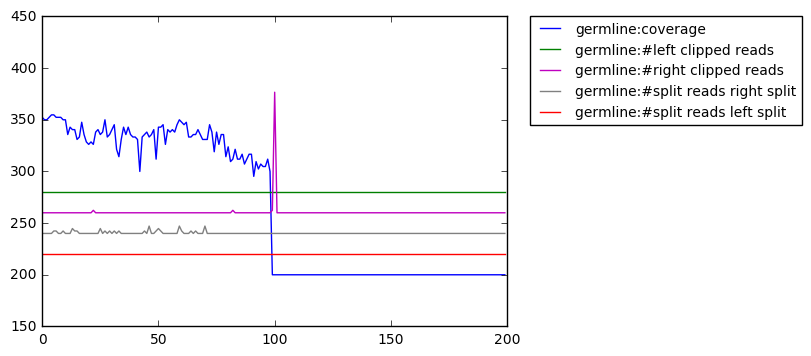

id: 21
Nanopore: DEL_start


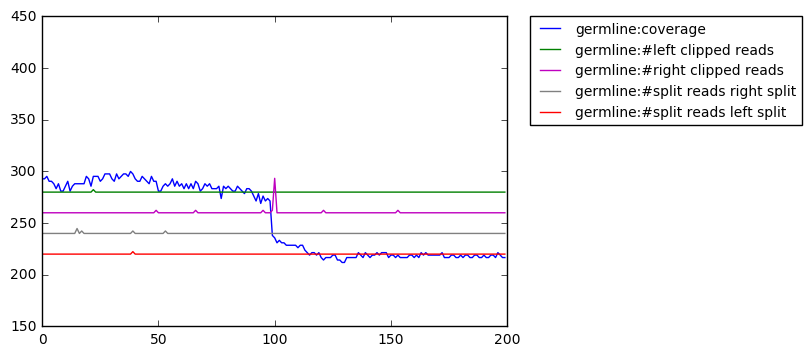

id: 22
Nanopore: DEL_end


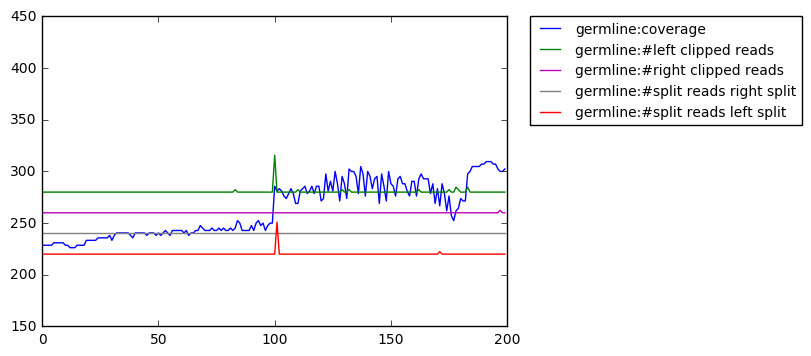

id: 23
Nanopore: DEL_start


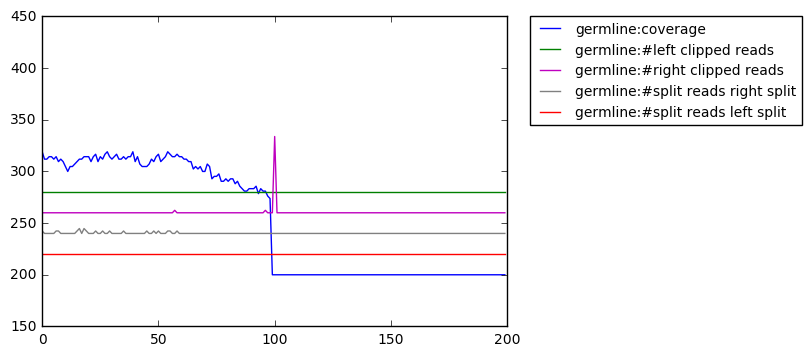

id: 24
Nanopore: DEL_end


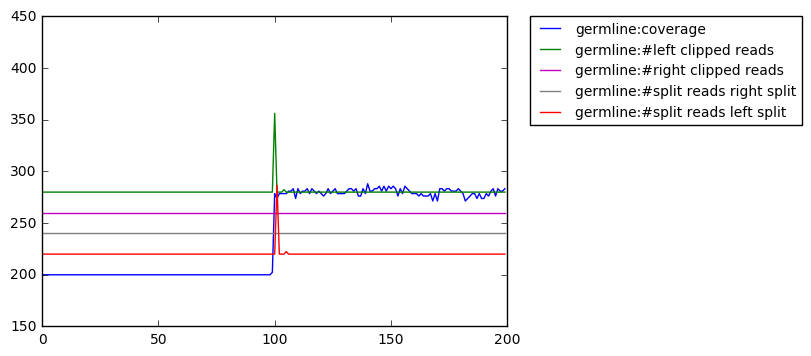

id: 25
Nanopore: DEL_start


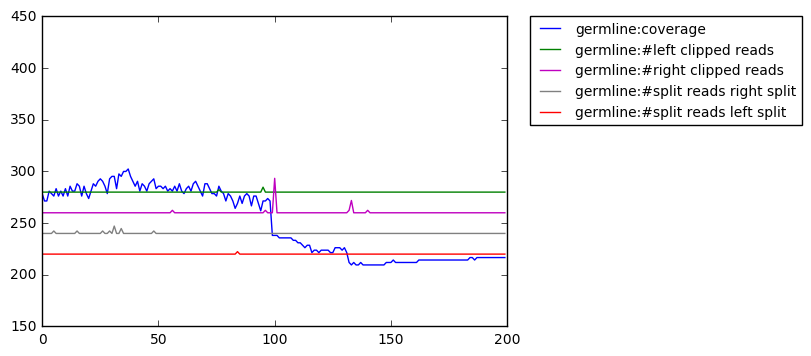

id: 26
Nanopore: DEL_end


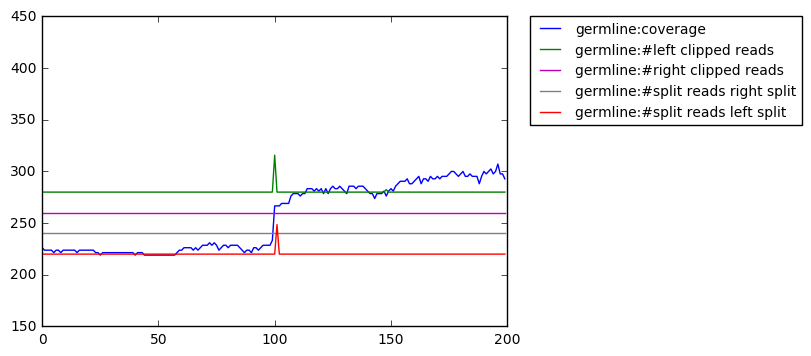

id: 27
Nanopore: DEL_start


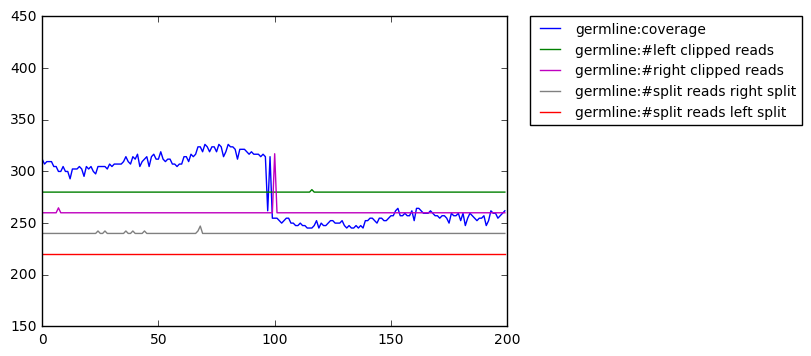

id: 28
Nanopore: DEL_start


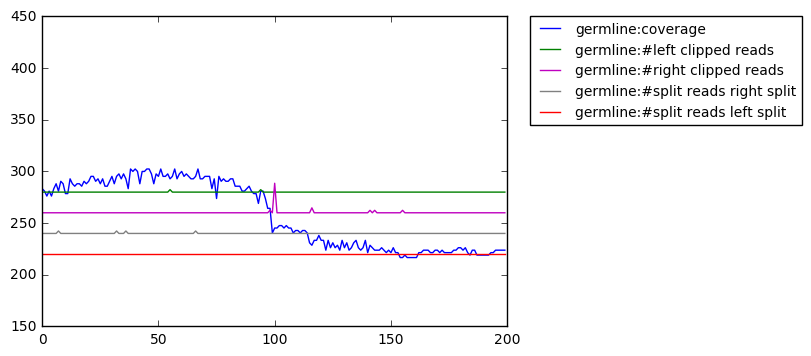

id: 29
Nanopore: DEL_start


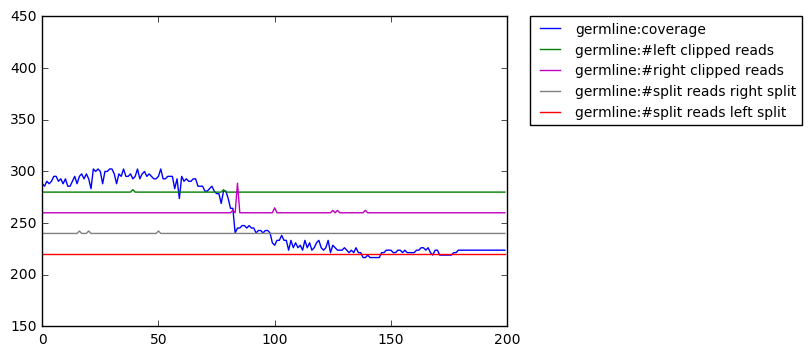

id: 30
Nanopore: DEL_end


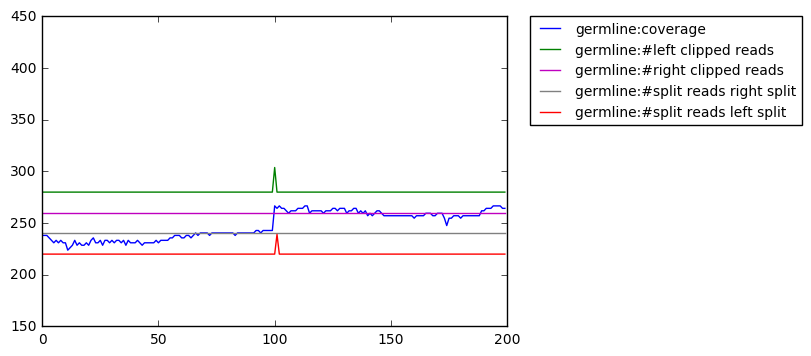

id: 31
Nanopore: DEL_start


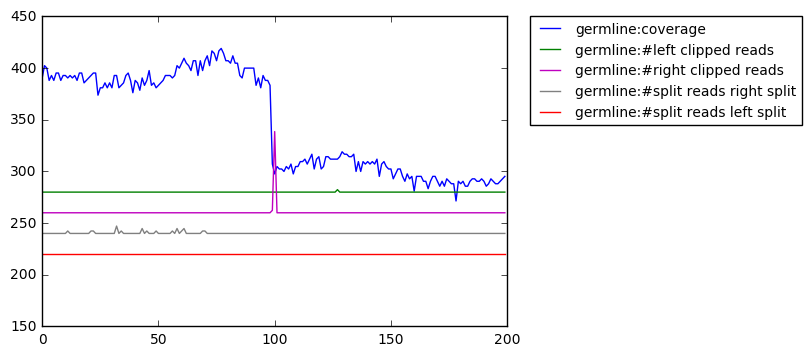

id: 32
Nanopore: DEL_end


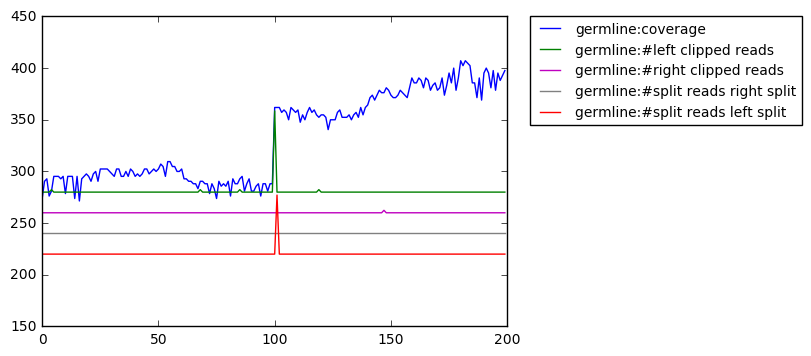

id: 33
Nanopore: DEL_start


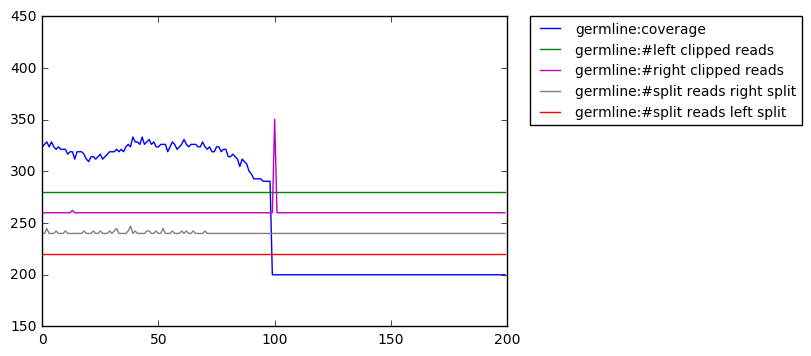

id: 34
Nanopore: DEL_end


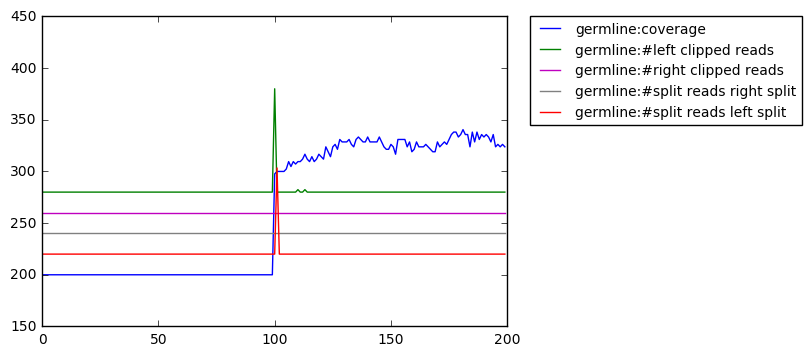

id: 35
Nanopore: DEL_end


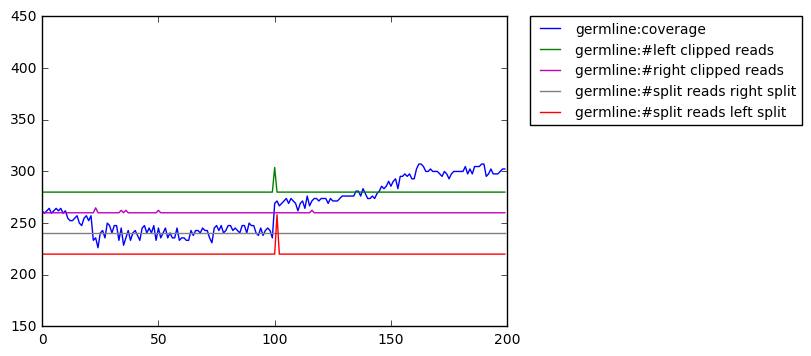

id: 36
Nanopore: DEL_start


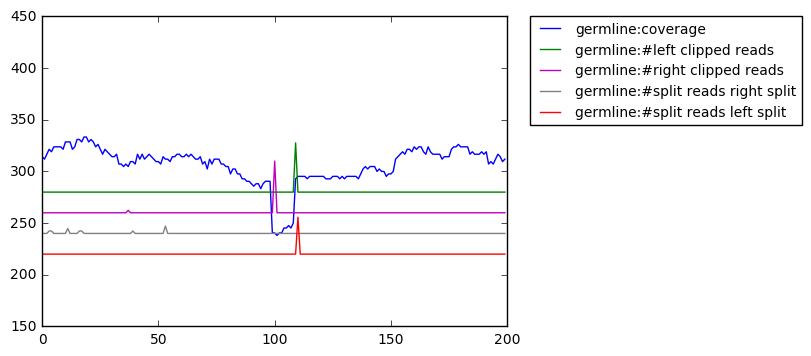

id: 37
Nanopore: DEL_start


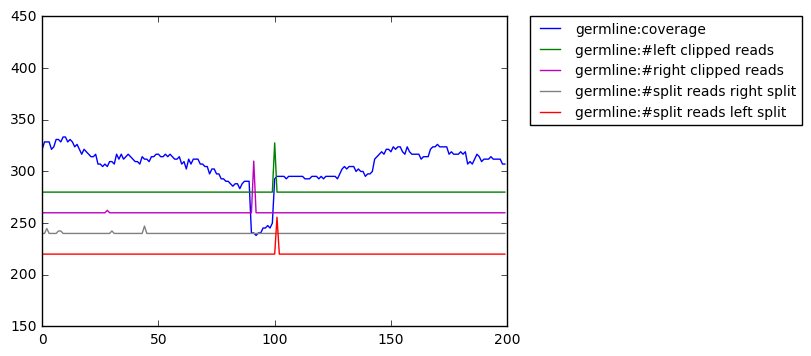

id: 38
Nanopore: DEL_end


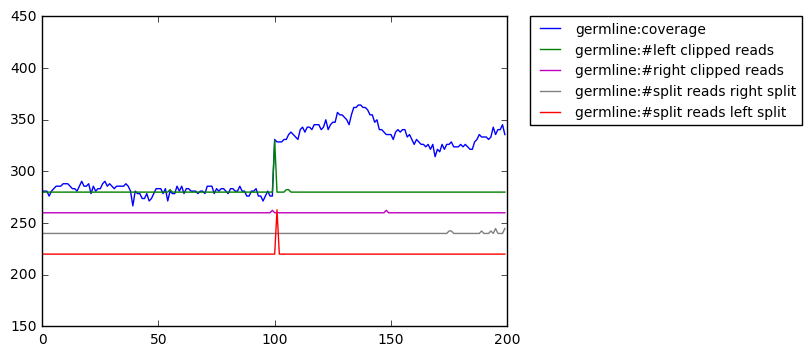

id: 39
Nanopore: DEL_start


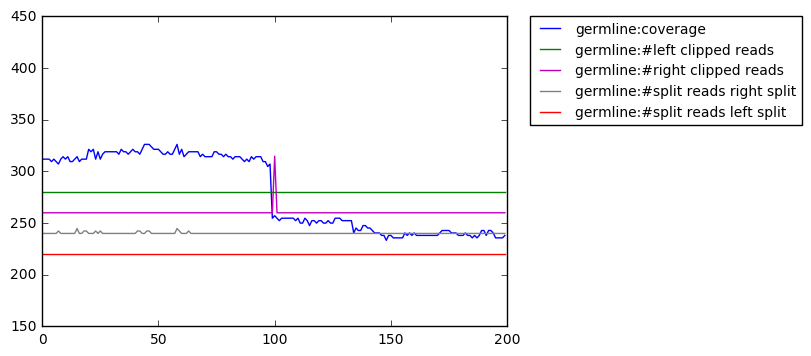

id: 40
Nanopore: DEL_start


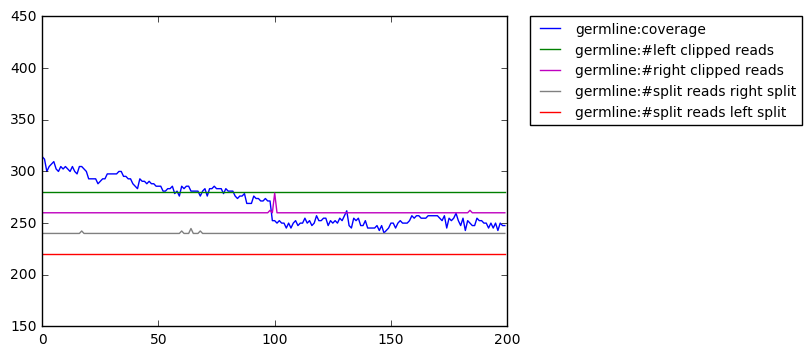

id: 41
Nanopore: DEL_start


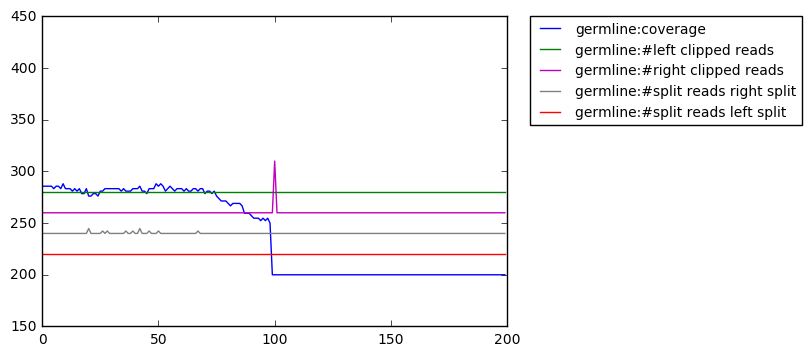

id: 42
Nanopore: DEL_end


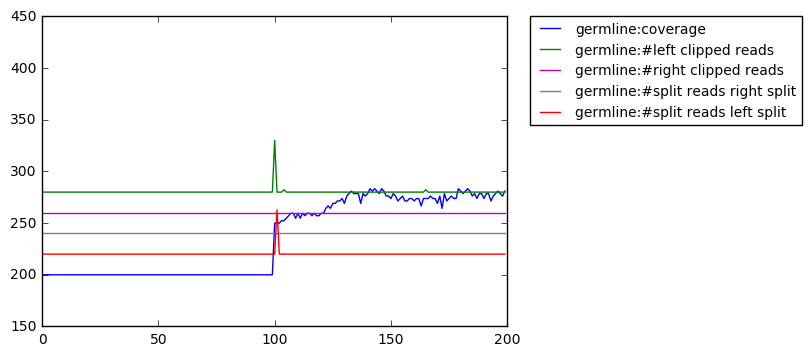

id: 43
Nanopore: DEL_end


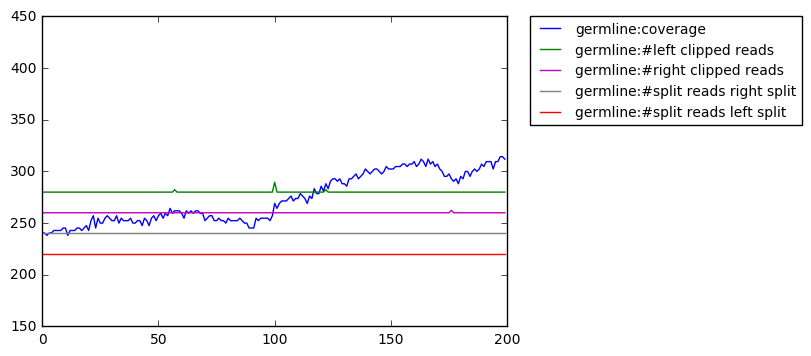

id: 44
Nanopore: DEL_start


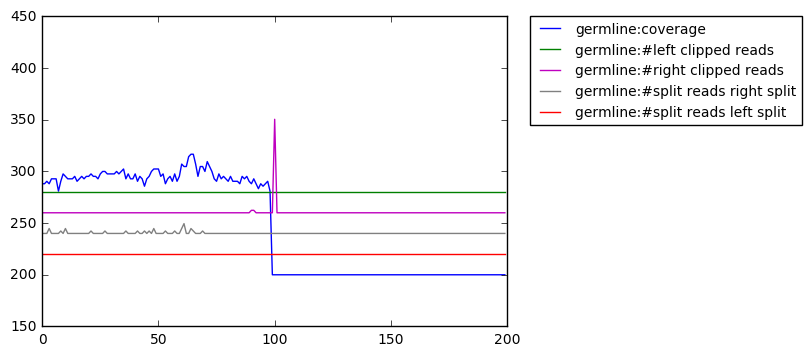

id: 45
Nanopore: DEL_end


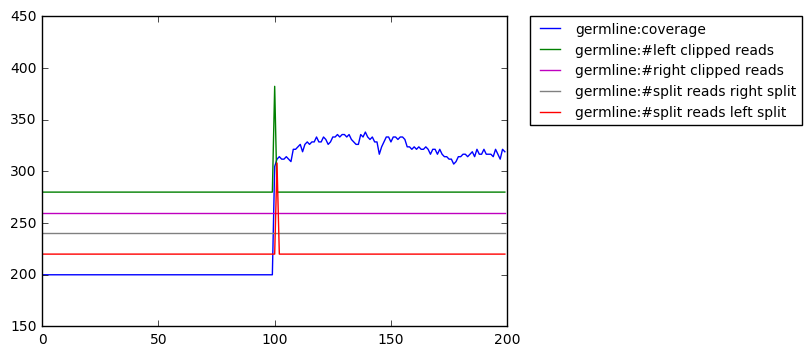

id: 46
Nanopore: DEL_start


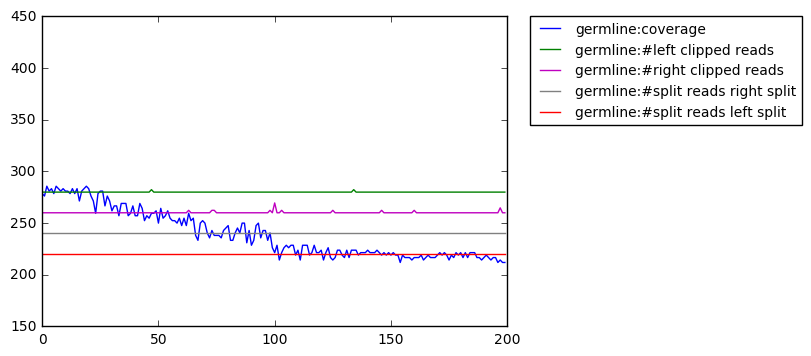

id: 47
Nanopore: DEL_end


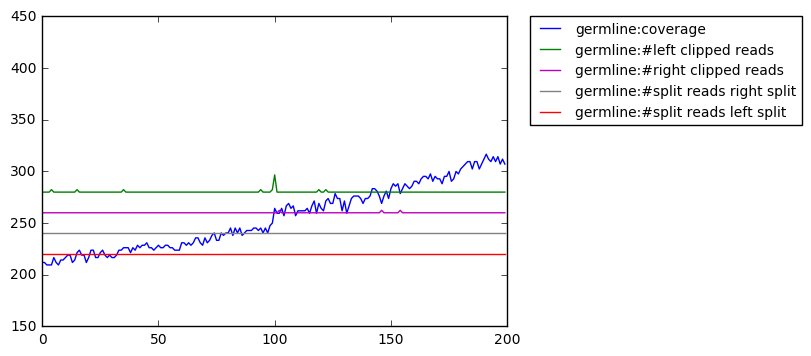

id: 48
Nanopore: DEL_start


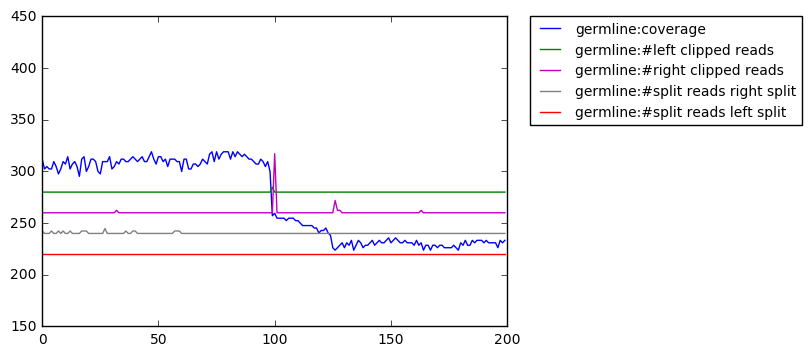

id: 49
Nanopore: DEL_start


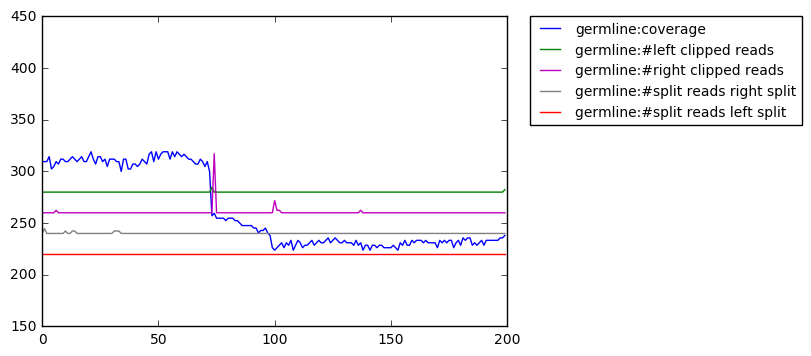

id: 50
Nanopore: DEL_end


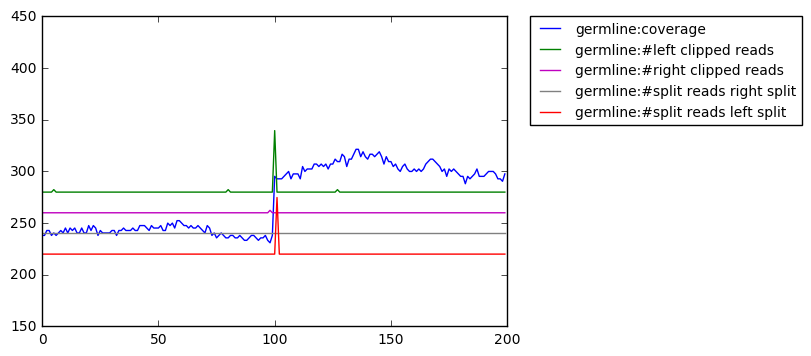

id: 51
Nanopore: DEL_start


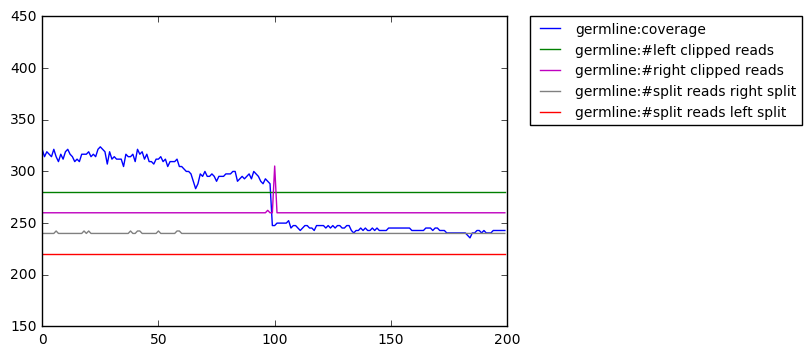

id: 52
Nanopore: DEL_end


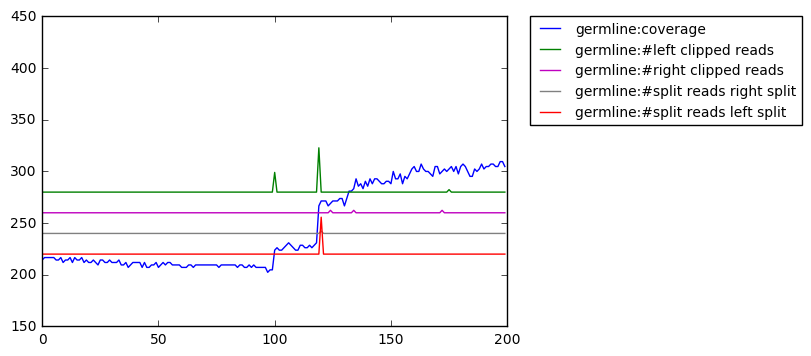

id: 53
Nanopore: DEL_end


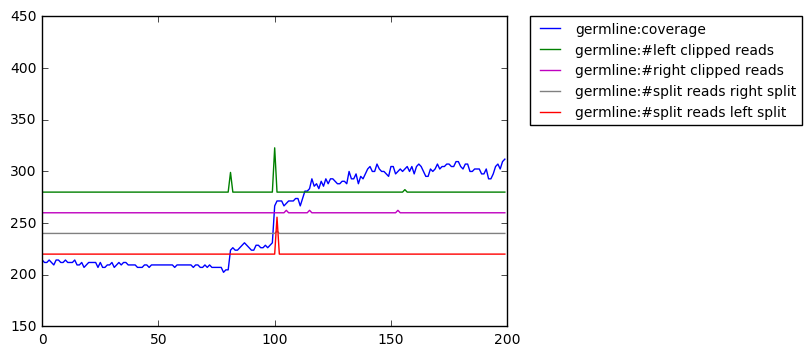

id: 54
Nanopore: DEL_start


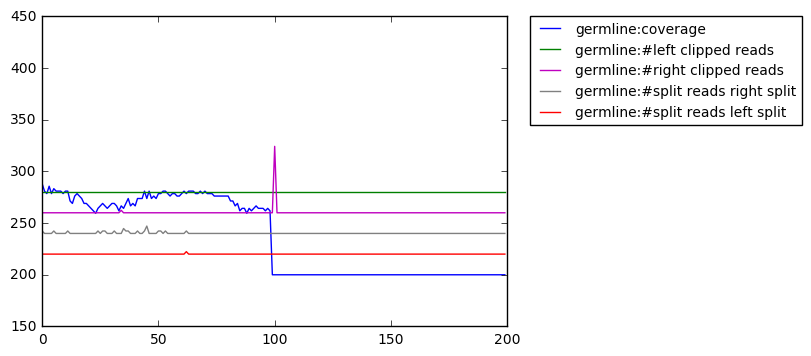

id: 55
Nanopore: DEL_end


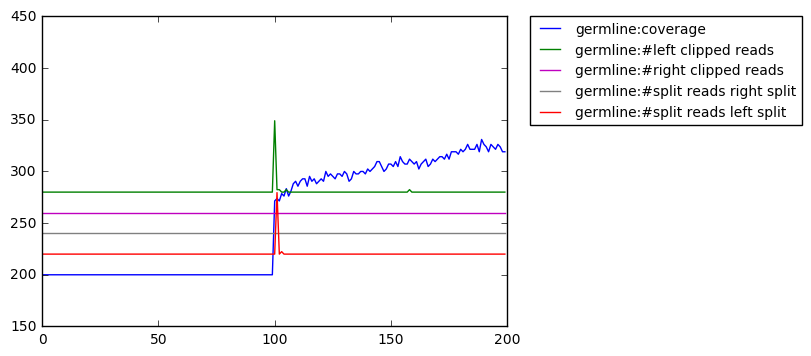

id: 56
Nanopore: DEL_start


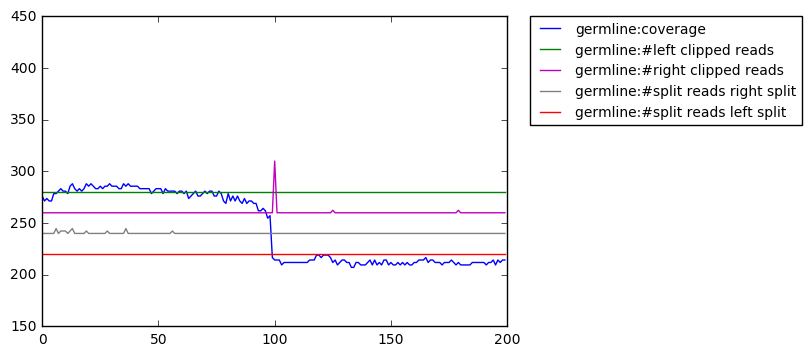

In [98]:
start_window = 0
n_windows = 57
plot_channels(start_window, n_windows)

id: 500
Nanopore: DEL_start


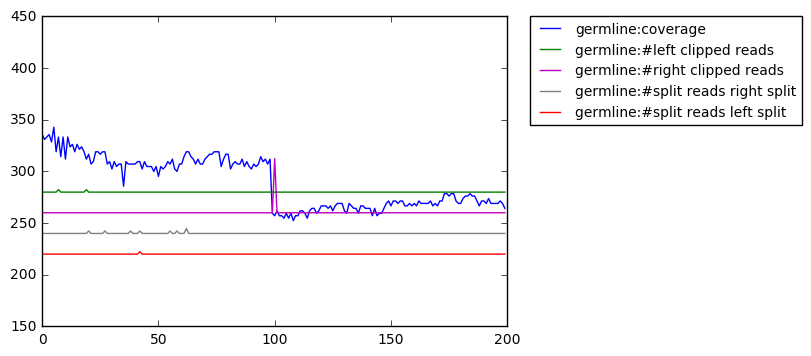

id: 501
Nanopore: DEL_start


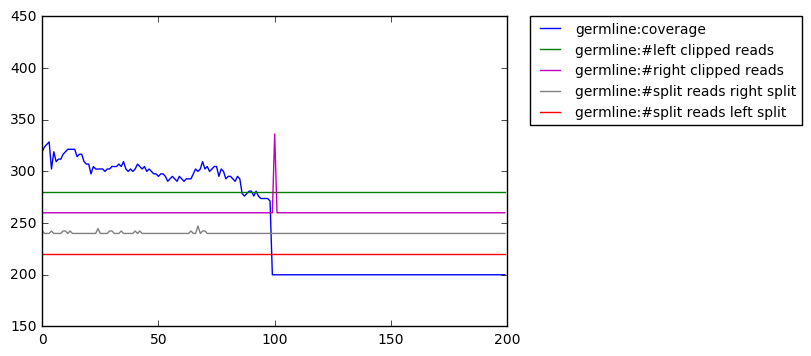

id: 502
Nanopore: DEL_end


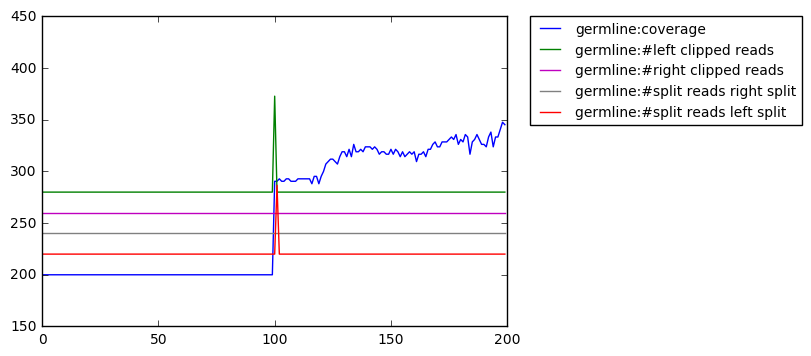

id: 503
Nanopore: DEL_start


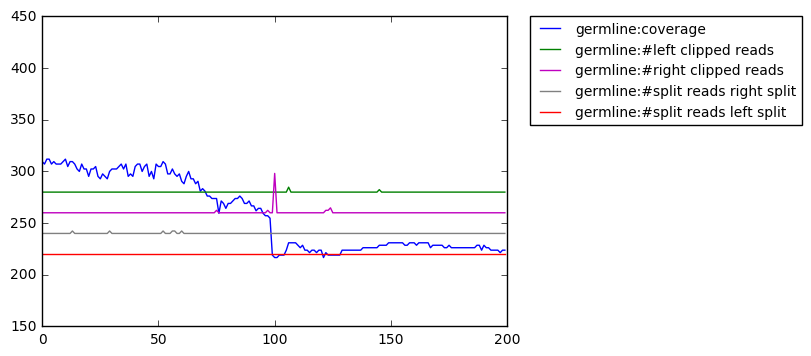

id: 504
Nanopore: DEL_end


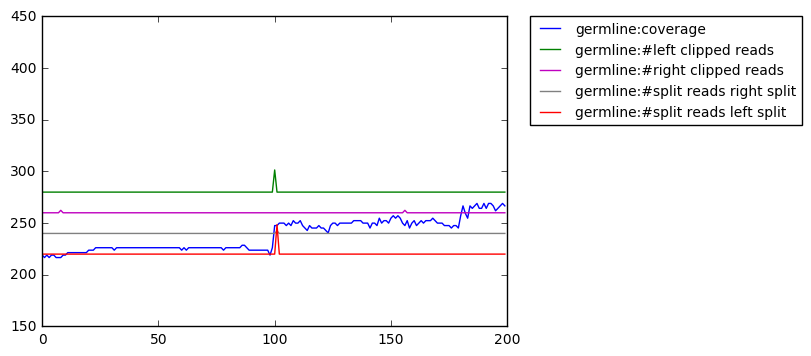

id: 505
Nanopore: DEL_start


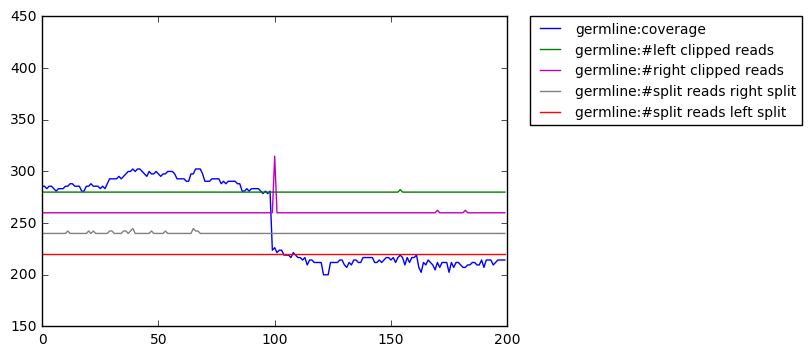

id: 506
Nanopore: DEL_end


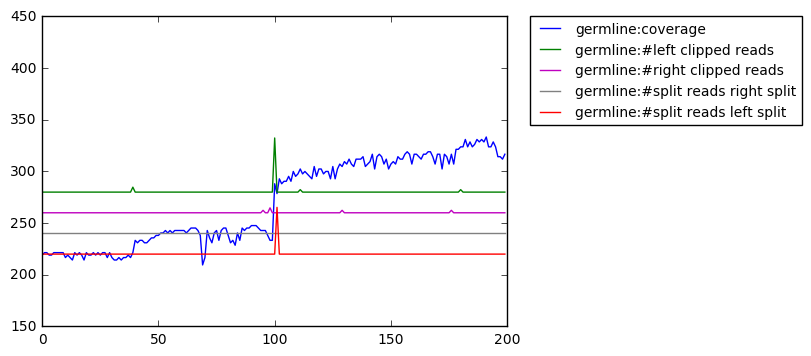

id: 507
Nanopore: DEL_start


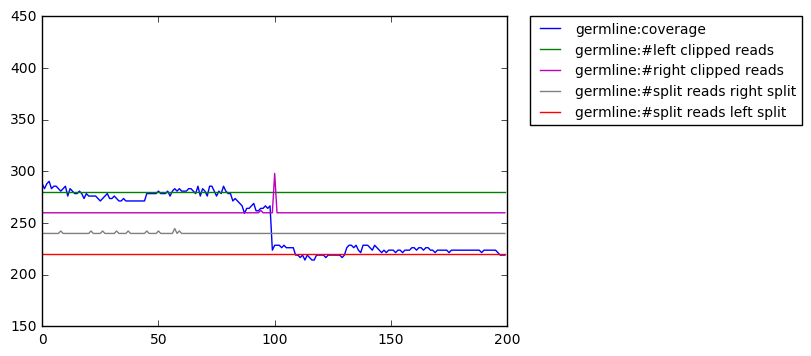

id: 508
Nanopore: DEL_end


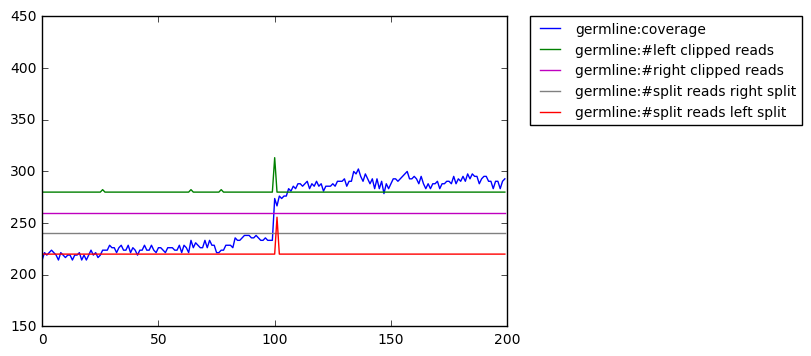

id: 509
Nanopore: DEL_start


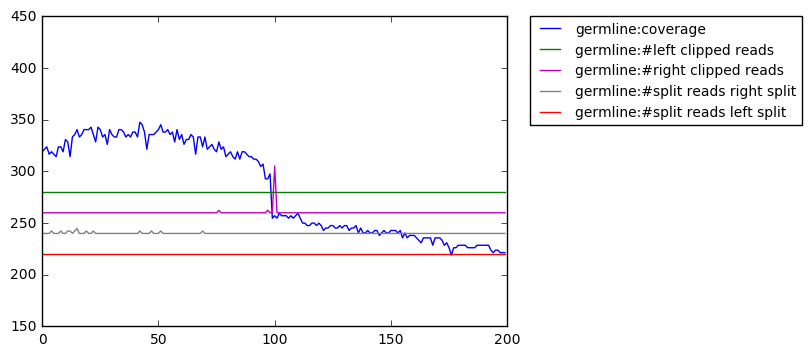

id: 510
Nanopore: DEL_end


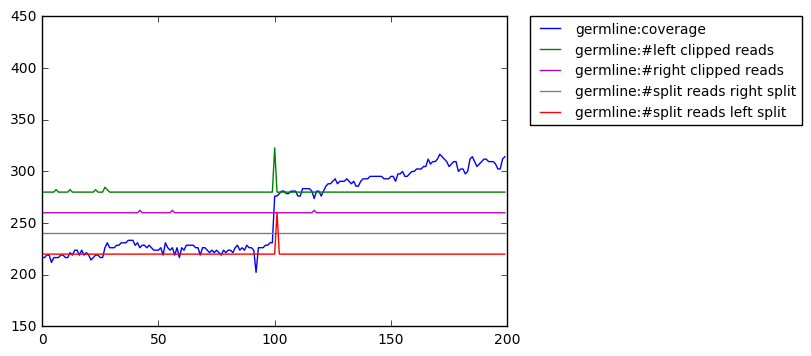

id: 511
Nanopore: DEL_start


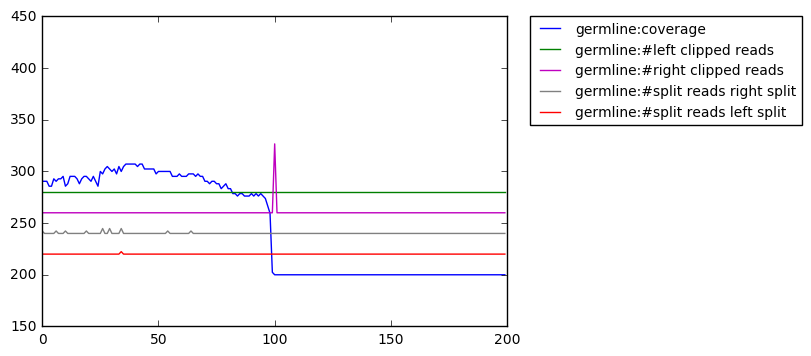

id: 512
Nanopore: DEL_end


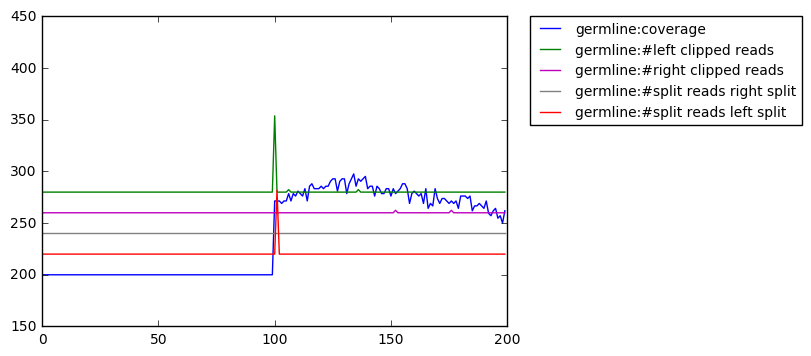

id: 513
Nanopore: DEL_start


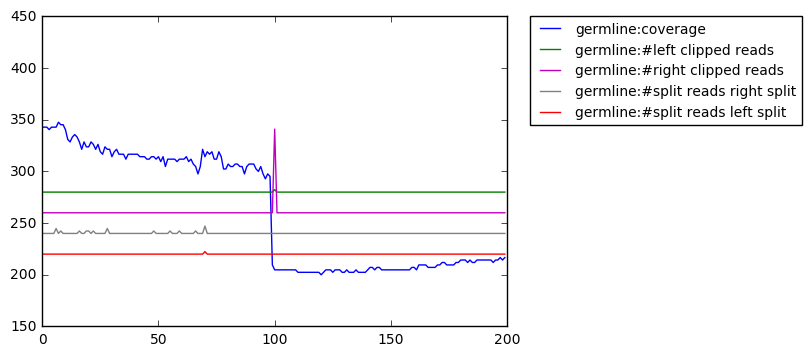

id: 514
Nanopore: DEL_end


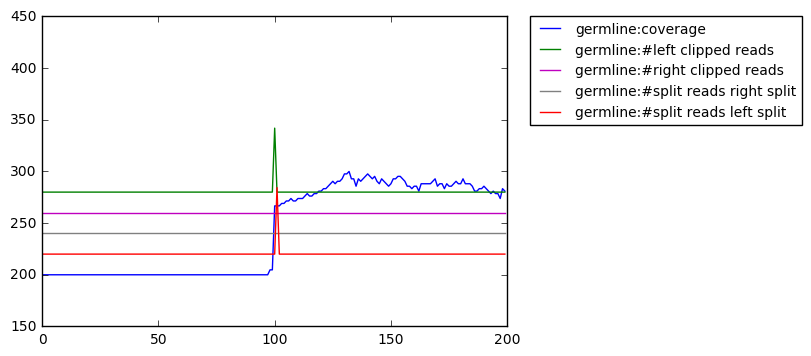

id: 515
Nanopore: DEL_start


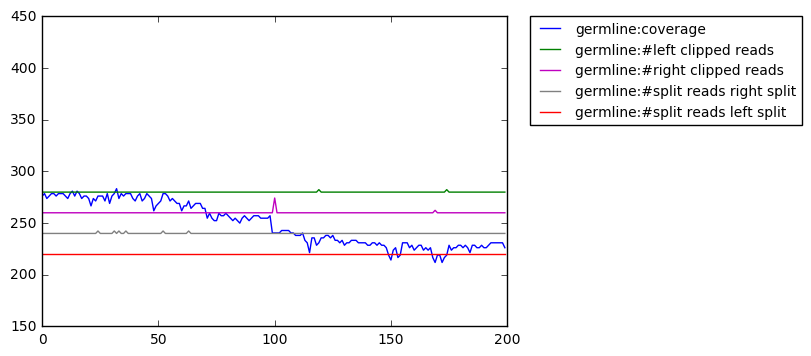

id: 516
Nanopore: DEL_end


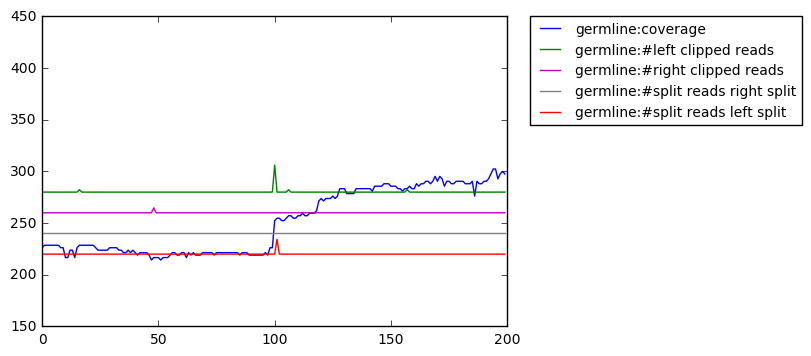

id: 517
Nanopore: DEL_start


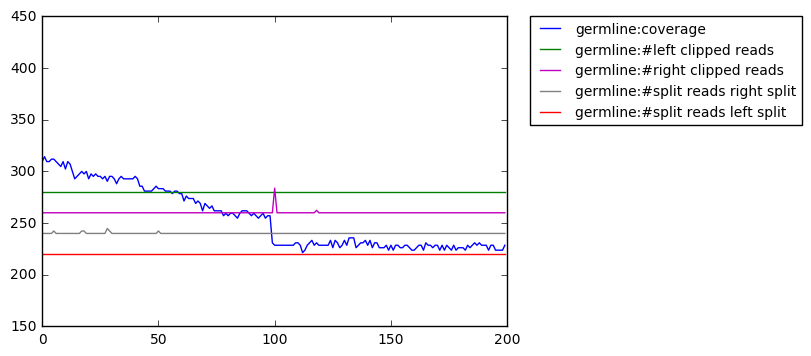

id: 518
Nanopore: DEL_start


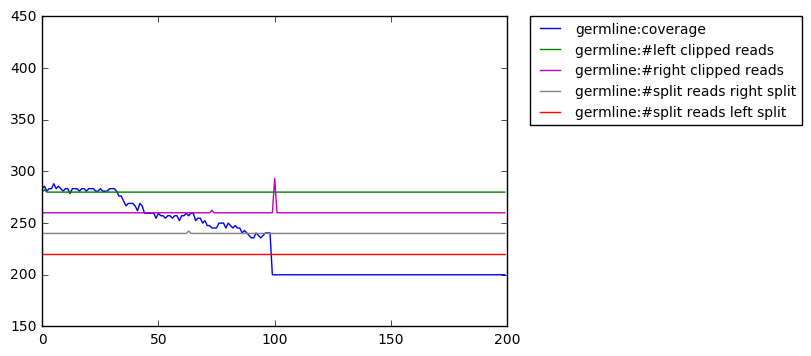

id: 519
Nanopore: DEL_start


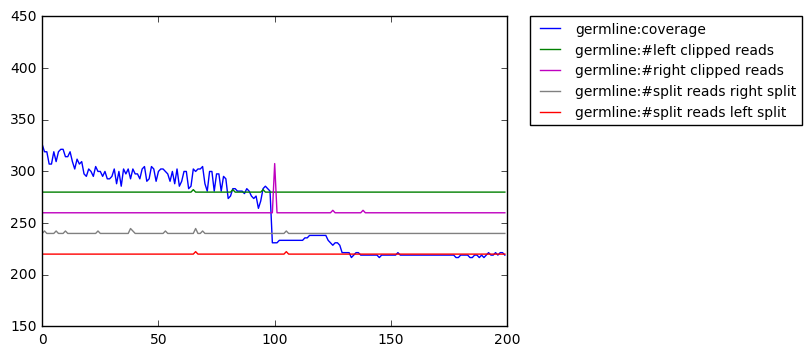

id: 520
Nanopore: DEL_end


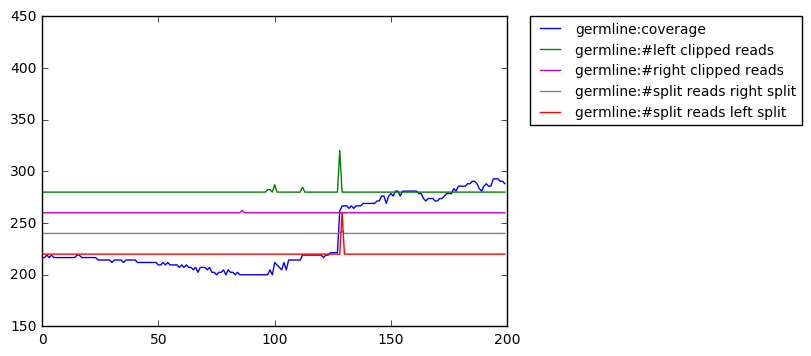

id: 521
Nanopore: DEL_end


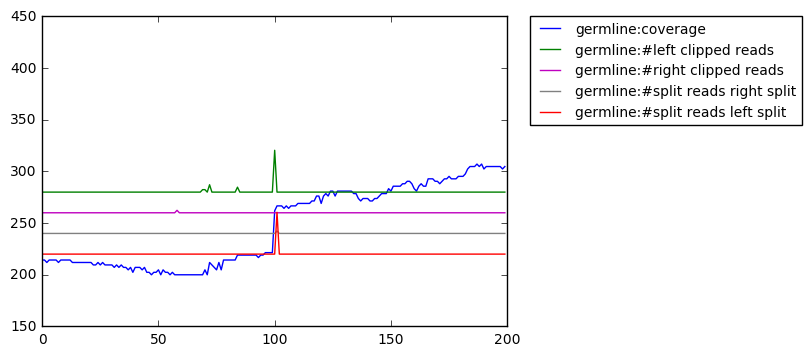

id: 522
Nanopore: DEL_start


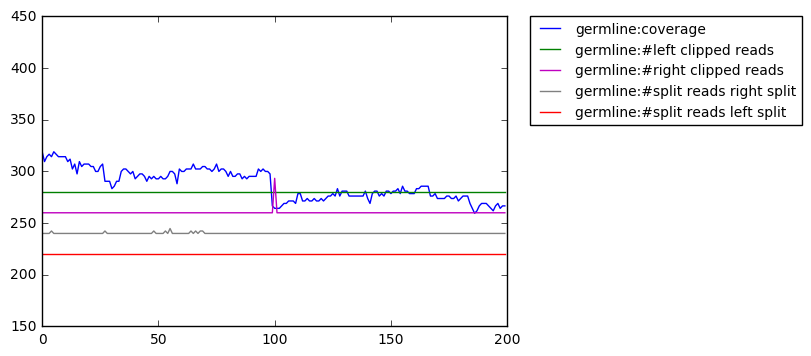

id: 523
Nanopore: DEL_end


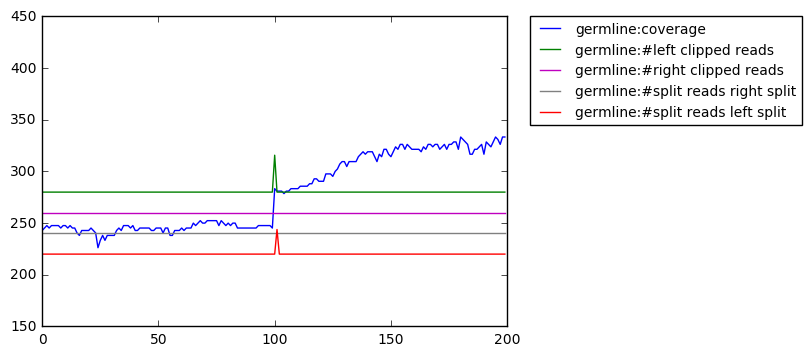

id: 524
Nanopore: DEL_start


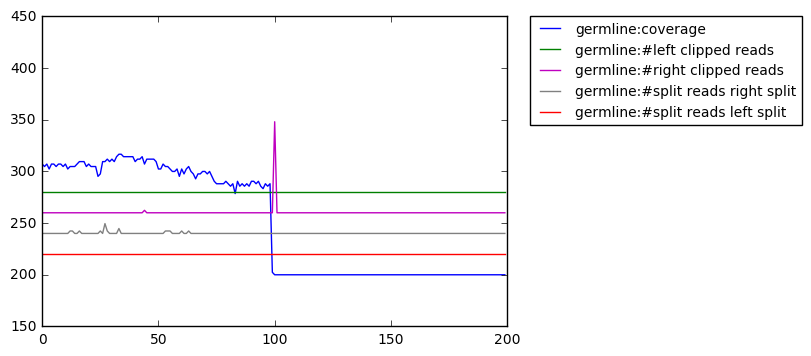

id: 525
Nanopore: DEL_end


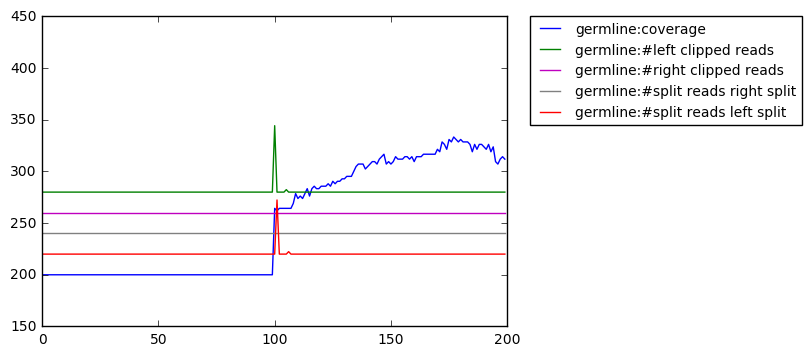

id: 526
Nanopore: DEL_start


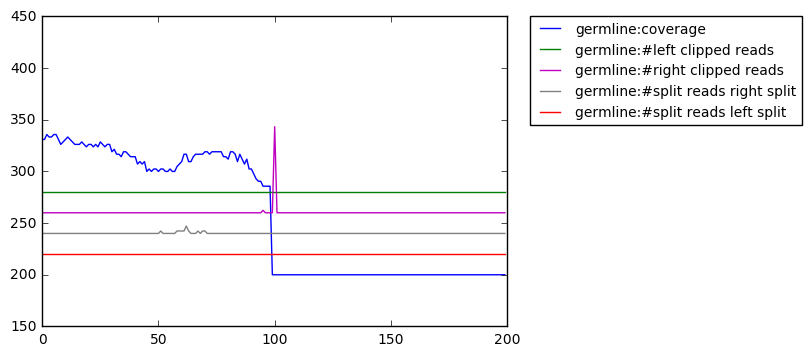

id: 527
Nanopore: DEL_end


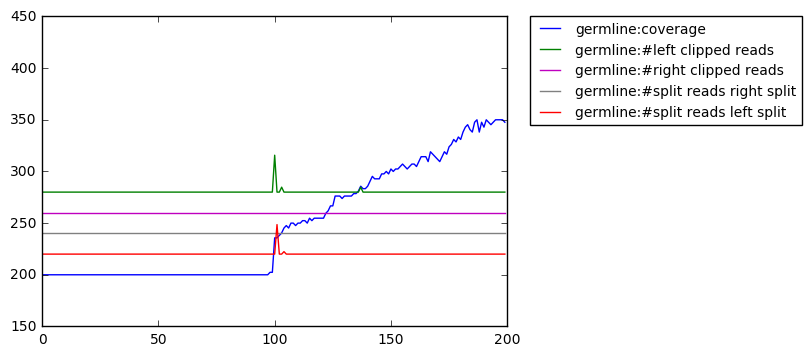

id: 528
Nanopore: DEL_start


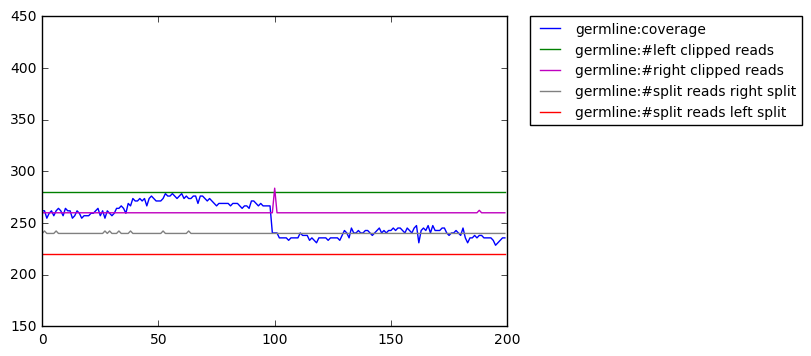

id: 529
Nanopore: DEL_end


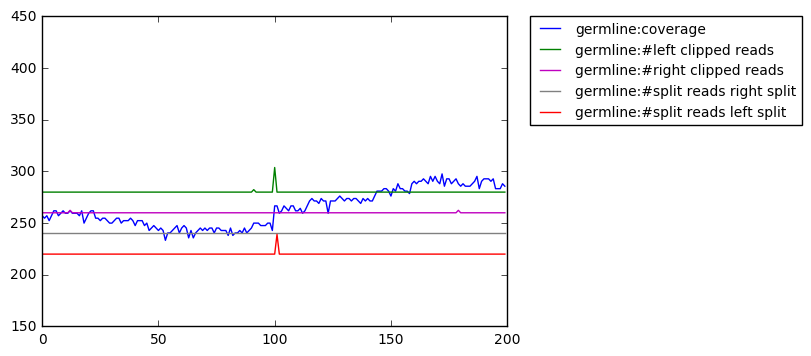

id: 530
Nanopore: DEL_start


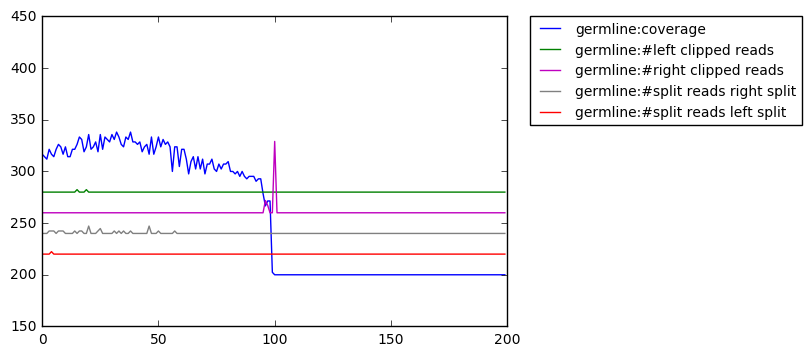

id: 531
Nanopore: DEL_start


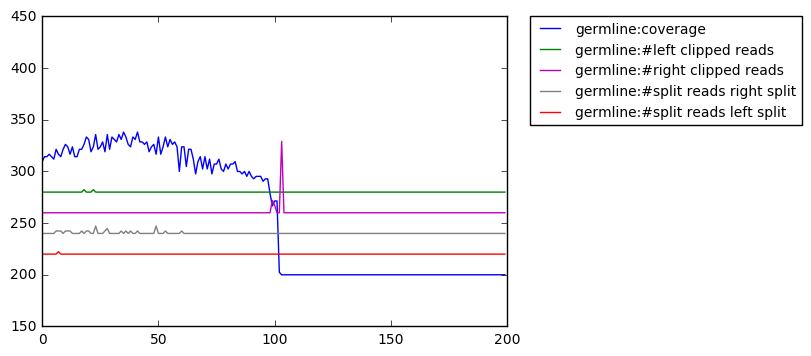

id: 532
Nanopore: DEL_start


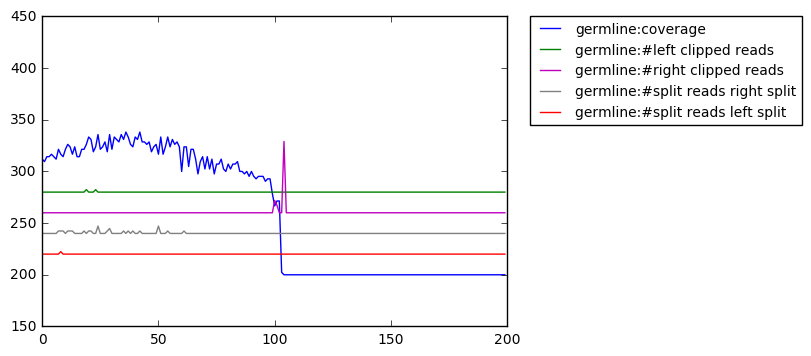

id: 533
Nanopore: DEL_start


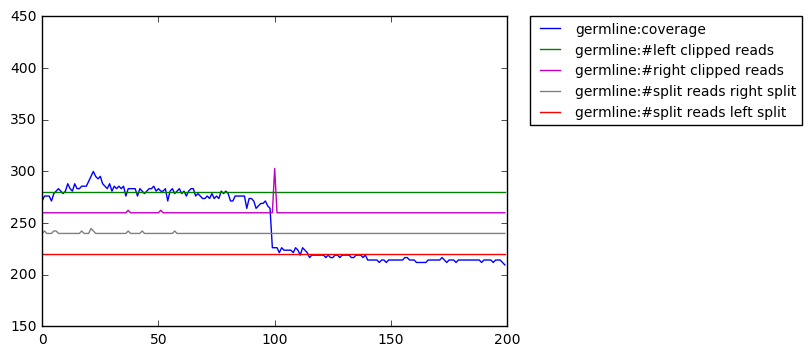

id: 534
Nanopore: DEL_end


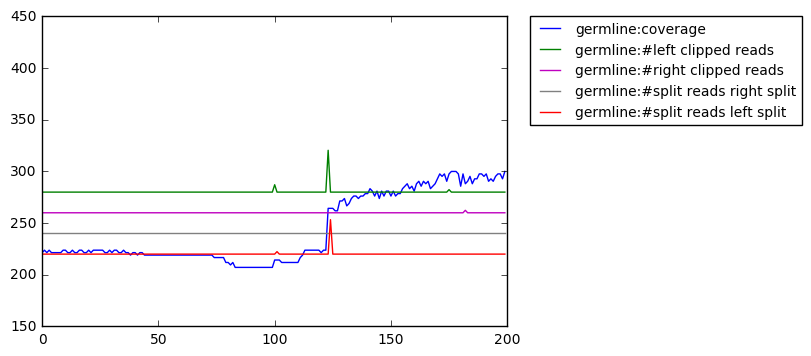

id: 535
Nanopore: DEL_start


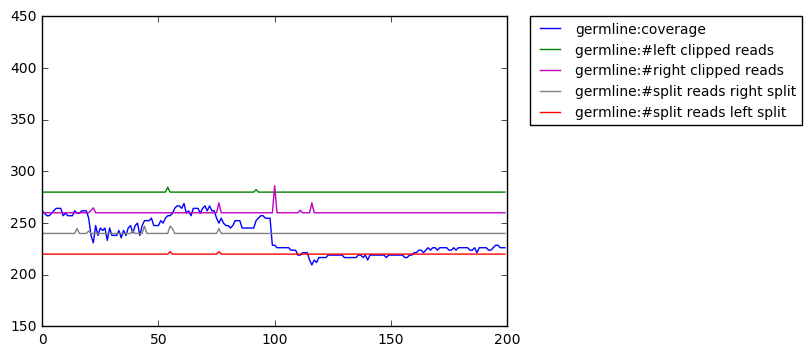

id: 536
Nanopore: DEL_start


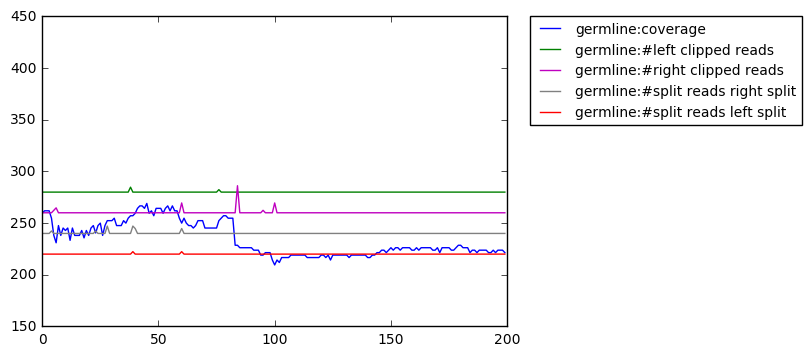

id: 537
Nanopore: DEL_start


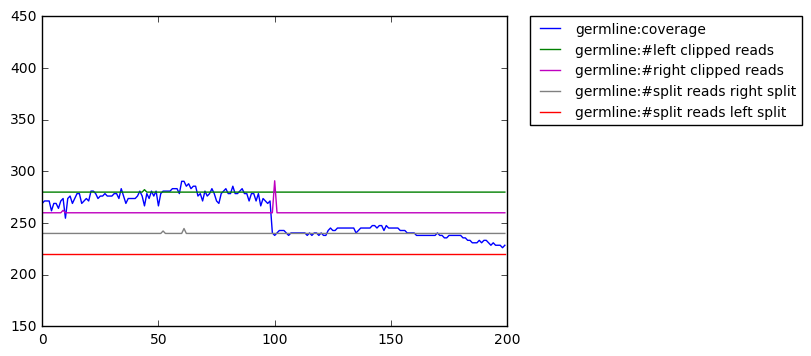

id: 538
Nanopore: DEL_end


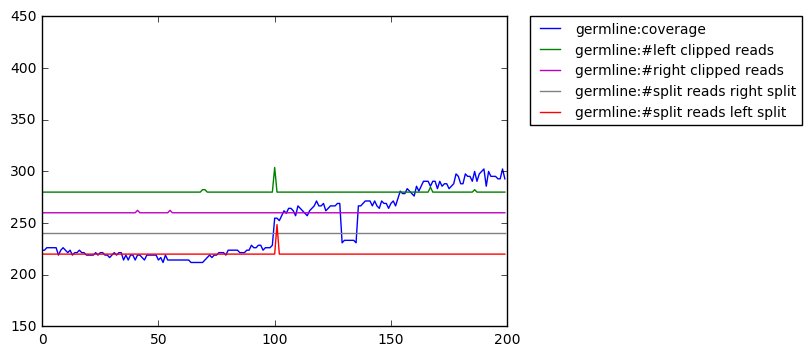

id: 539
Nanopore: DEL_start


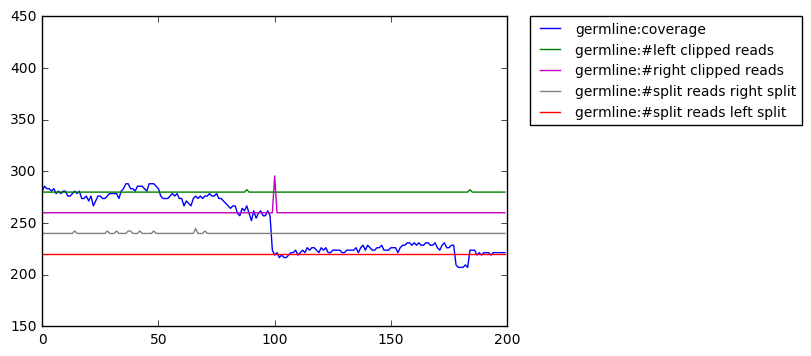

id: 540
Nanopore: DEL_end


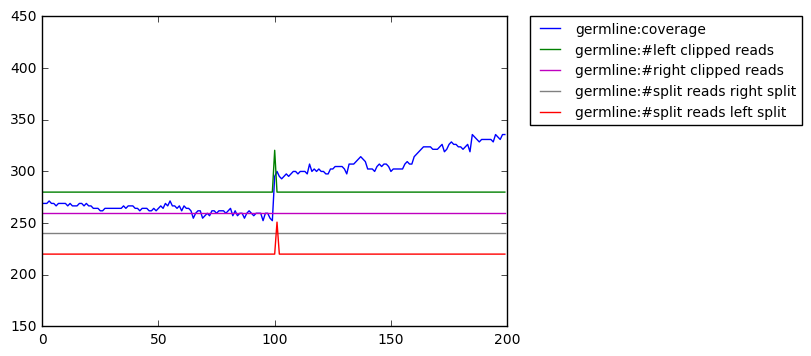

id: 541
Nanopore: DEL_start


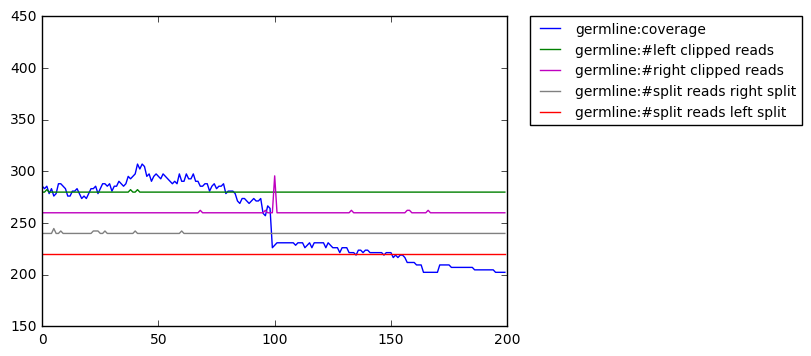

id: 542
Nanopore: DEL_end


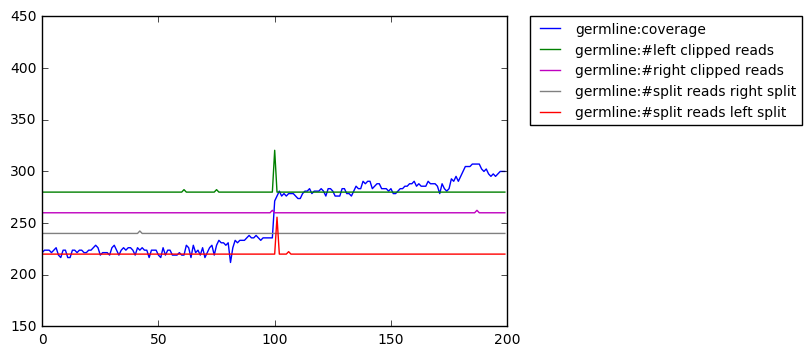

id: 543
Nanopore: DEL_start


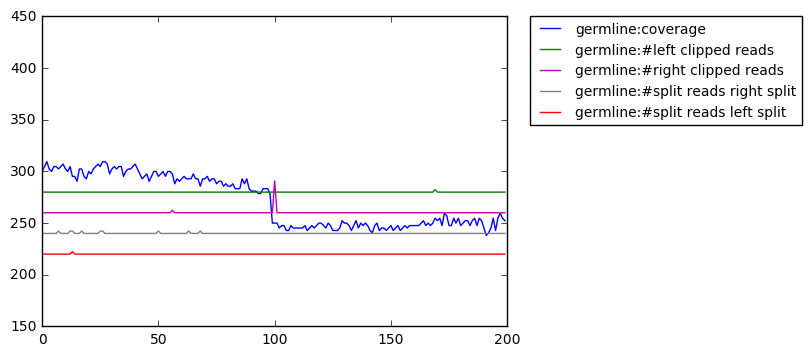

id: 544
Nanopore: DEL_end


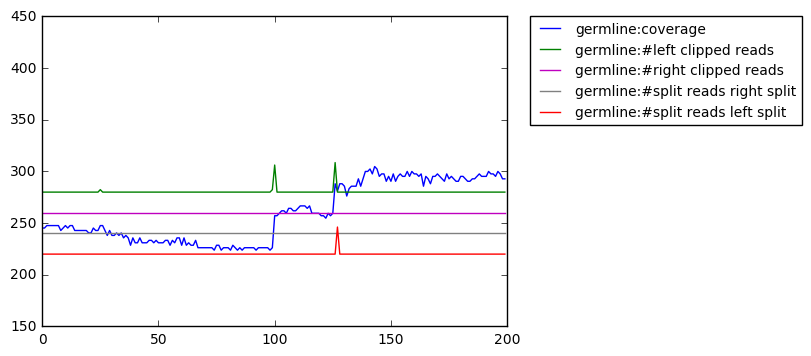

id: 545
Nanopore: DEL_end


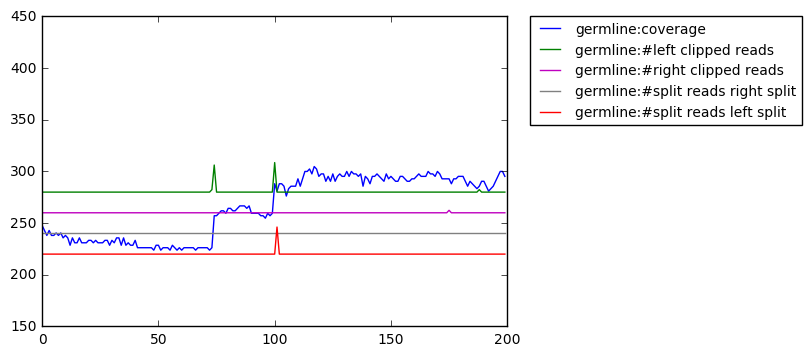

id: 546
Nanopore: DEL_start


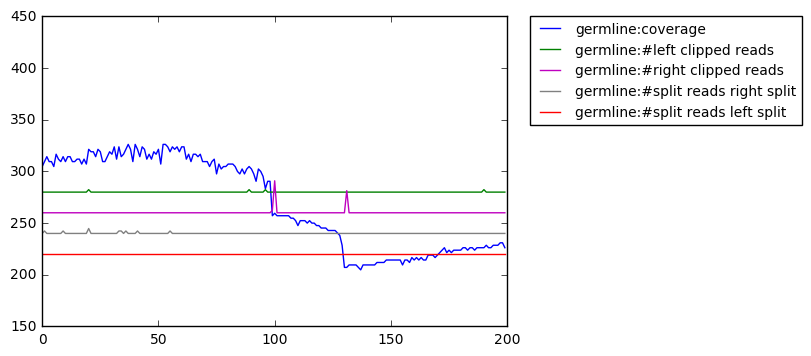

id: 547
Nanopore: DEL_end


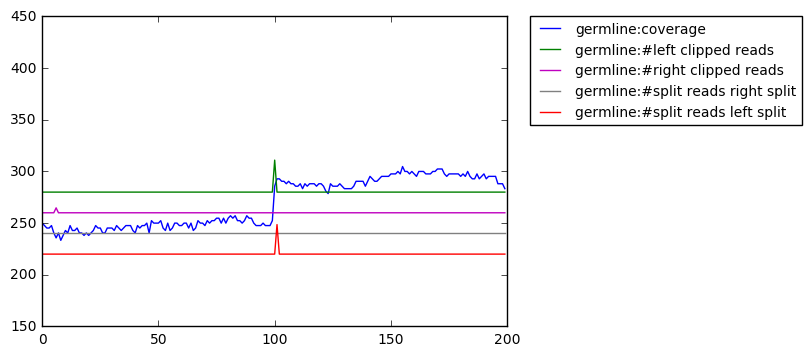

id: 548
Nanopore: DEL_start


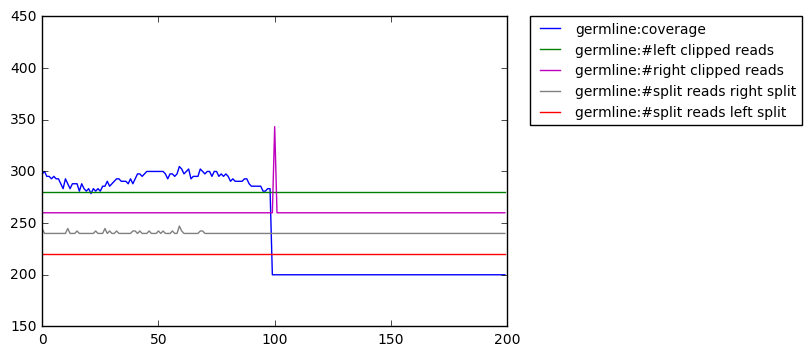

id: 549
Nanopore: DEL_end


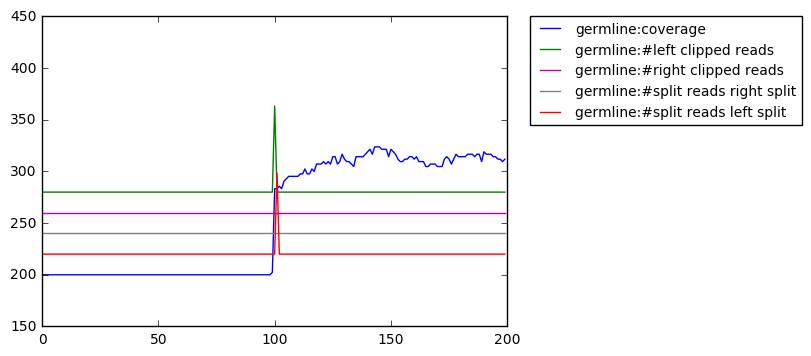

In [99]:
n_windows = 50
start_window = 500
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [100]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_test[0][0])
print(len(X_test[0][0]))

5


## Prepare the labels in McFly format

In [101]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'noSV': 2, 'DEL_start': 1, 'DEL_end': 0}


In [102]:
#y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
#y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
#y_train_binary = to_categorical(y_train)
#y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [103]:
y_test_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [104]:
X_train.shape

(0,)

## Reload the trained model

In [105]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_26_10_16xoversample_NoDiff_9749')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [106]:

model = model_reloaded 
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [107]:
mapclasses = {'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [108]:
labels = [i[0] for i in dict_sorted]

In [109]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

DEL_end  DEL_start    noSV
DEL_end        288          4      10
DEL_start        6        326      12
noSV          3460       5128  236873

## Test best current model on testset

### Overall accuracy on the test set:

In [110]:
%%time
score_test = model.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.30222914347100999, 0.96497458422556037]
Wall time: 1min 34s


In [111]:
#9659 best test results : 9513